In [7]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [8]:
device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (torch.cuda.is_available())

True


In [9]:
transform = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])
transform_training = transforms.Compose([transforms.Resize((32,32)),
                                transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(10),
                                 transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                 transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_training)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [11]:
classes=('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship' , 'truck')

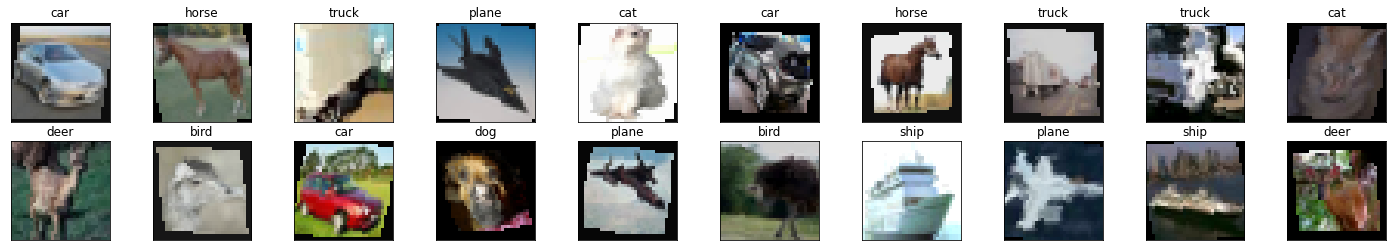

In [12]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])
  

In [61]:
class LeNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(3,16,3,1,padding=1)
        self.conv2=nn.Conv2d(16,32,3,1, padding=1)
        self.conv3=nn.Conv2d(32,64,3,1, padding=1)
        self.conv4=nn.Conv2d(64,128,3,1, padding=1)
        self.fc1=nn.Linear(2*2*128, 500)
        self.dropout1=nn.Dropout(0.5)
        self.fc2=nn.Linear(500,10)
    def forward(self, x):
        im = F.relu(self.conv1(x))
        im=F.max_pool2d(im,2,2)
        im=F.relu(self.conv2(im))
        im=F.max_pool2d(im,2,2)
        im=F.relu(self.conv3(im))
        im=F.max_pool2d(im,2,2)
        im=F.relu(self.conv4(im))
        im=F.max_pool2d(im,2,2)
        im=im.view(-1, 2*2*128)
        im=F.relu(self.fc1(im))
        im=self.dropout1(im)
        im=self.fc2(im)
        return im

In [62]:
model=LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [63]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [64]:
epochs = 13
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
print('Training in process...')

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels=labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs=val_inputs.to(device)
        val_labels=val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))
    
print ('Training Ends')

Training in process...
epoch : 1
training loss: 1.7426, acc 35.1940 
validation loss: 1.4265, validation acc 48.1200 
epoch : 2
training loss: 1.4162, acc 48.5720 
validation loss: 1.2508, validation acc 54.2100 
epoch : 3
training loss: 1.2792, acc 54.2980 
validation loss: 1.1535, validation acc 58.5300 
epoch : 4
training loss: 1.1866, acc 57.4980 
validation loss: 1.0559, validation acc 62.5700 
epoch : 5
training loss: 1.1053, acc 60.8860 
validation loss: 1.0103, validation acc 64.4000 
epoch : 6
training loss: 1.0528, acc 62.7560 
validation loss: 0.9602, validation acc 66.2400 
epoch : 7
training loss: 0.9953, acc 64.7620 
validation loss: 0.9674, validation acc 66.5500 
epoch : 8
training loss: 0.9575, acc 66.3820 
validation loss: 0.8874, validation acc 68.4400 
epoch : 9
training loss: 0.9235, acc 67.6640 
validation loss: 0.8551, validation acc 70.4500 
epoch : 10
training loss: 0.8942, acc 68.7920 
validation loss: 0.8703, validation acc 69.7100 
epoch : 11
training loss: 

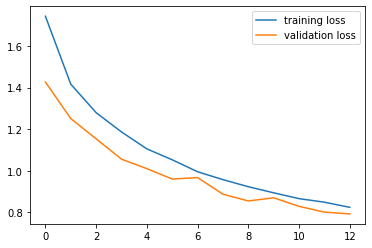

In [65]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

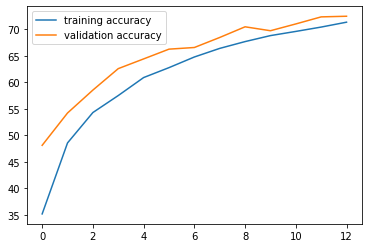

In [66]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [67]:
import PIL.ImageOps

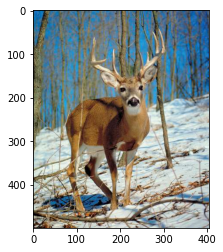

In [75]:
import requests 
from PIL import Image
url='https://cdn.britannica.com/s:700x500/40/109040-050-62EEDEA6/Male-white-tailed-deer.jpg'
response=requests.get(url,stream=True)
img= Image.open(response.raw)
plt.imshow(img)


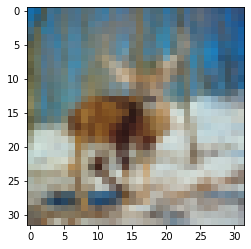

In [76]:
img=transform(img)
plt.imshow(im_convert(img))

In [77]:
image2=img.to(device)

# img=img[0].unsqueeze(0).unsqueeze(0)

image2 = image2.unsqueeze(0)
# plt.imshow(im_convert(image2))
# print (img[0].unsequeeze(0))

# img=img.view(img.shape[0],-1)
# print(image2.shape)
# print (images[0].shape)
output=model(image2)
_,pred=torch.max(output,1)
print(classes[pred.item()])



deer


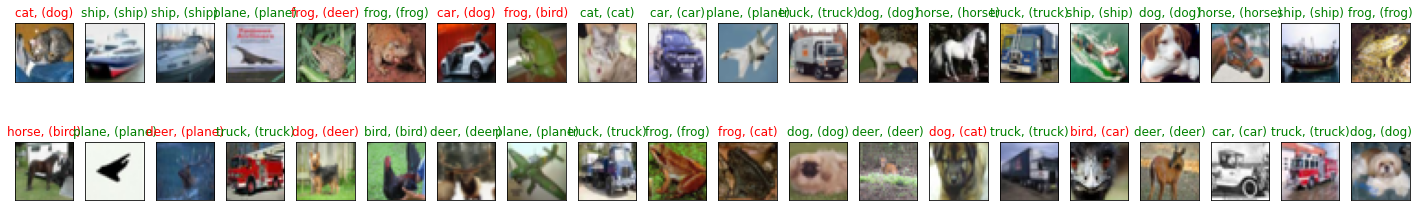

In [71]:
dataiter=iter(validation_loader)
images1, labels1=dataiter.next()
images1=images1.to(device)
labels1=labels1.to(device)
outputs1=model(images1)
_,preds1= torch.max(outputs1,1)

fig= plt.figure(figsize=(25,4))

for idx in np.arange(40):
    ax=fig.add_subplot(2,20, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images1[idx]))
    ax.set_title('{}, ({})'.format(classes[labels1[idx].item()],classes[preds1[idx].item()]), color='green' if preds1[idx]==labels1[idx] else 'red')

In [24]:
torch.cuda.get_device_name(0)

'GeForce MX130'